In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn import datasets
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from typing import Tuple, List
from sklearn.preprocessing import MinMaxScaler
import warnings
import scipy
import numba as nb
import requests
import sys

sys.path.insert(1, "./umap")
warnings.filterwarnings('always')

def visualize(x, y, axis):
    colors = cm.rainbow(np.linspace(0, 1, max(y) - min(y) + 1))
    for sample_index in range(len(x)):
        sample = x[sample_index]
        label = y[sample_index]
        axis.scatter(sample[0], sample[1], color=colors[label], s=10)

def visualize_loss(function):
    X = np.arange(0.1, 0.9, 0.1)
    Y = np.arange(0.1, 0.9, 0.1)
    X = np.exp(-X ** 2) + 1e-8
    Y = 1 / ((1 + Y ** 2) + 1e-8) + 1e-8
    X, Y = np.meshgrid(X, Y)
    Z = function(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(azim=30)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def evaluate_visualizations(
    min_neighbors: int,
    max_neighbors: int,
    low_dimension_factory,
    show_cross_entropy: bool = False,
    one_run: bool = False):
    def evaluate_umap(axis, neighbors: List[int]):
        print(f'Running UMAP for neighbors count: {neighbors}')
        axis.set_title(f'Neighbors: {neighbors}')
        response = low_dimension_factory(neighbors)
        visualize(response[0], labels, axis)
        y = MinMaxScaler().fit_transform(response[0])
        return response
    figure, axes = plt.subplots(2, 2, figsize=(12, 12))
    evaluate_umap(axes[0, 0], [min_neighbors])
    if one_run:
        return []
    evaluate_umap(axes[0, 1], [max_neighbors])
    response = evaluate_umap(axes[1, 0], [min_neighbors, max_neighbors])
    if len(response) > 1:
        axes[1, 1].plot(response[1], label="Weighted Cross Entropy")
        axes[1, 1].legend()
    if len(response) > 2 and show_cross_entropy:
        axes[1, 1].plot(response[2], label="Cross Entropy")
        axes[1, 1].legend()
    return response[1] if len(response) > 1 else None

dataset = datasets.make_circles(n_samples=1500, factor=0.5, noise=0.05)
labels = dataset[1] #[0:200]
digits = dataset[0] #[0:200]
digits.shape

(1500, 2)

## Parameters

In [2]:
distances = euclidean_distances(digits, digits)
MIN_NEIGHBORS = 5
MAX_NEIGHBORS = 10
FULL_MIN_NEIGHBORS = int(len(digits) / 2)
FULL_MAX_NEIGHBORS = len(digits)
MIN_DIST = 1.0
ITERATION_LIMIT = 150

## L1. Fuzzy Cross Entropy

/data/umap/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


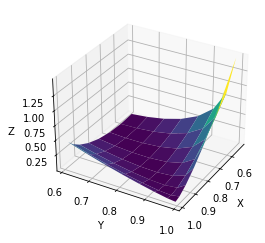

In [3]:
from algorithm import umap, GradientOptimizer, Adam, CrossEntropyLoss
visualize_loss(lambda P, Q: P * np.log(P / Q) + (1 - P) * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[1]: loss 695122.1484293648
[50]: loss 24967.687956924758
[100]: loss 18201.78504871795
[150]: loss 16469.0111927561
Running UMAP for neighbors count: [1500]
[1]: loss 6598854.679856914
[50]: loss 1007353.9949158411
[100]: loss 958267.6002976611
[150]: loss 957934.8010845486
Running UMAP for neighbors count: [10, 1500]
[1]: loss 4371198.934274895
[50]: loss 2120306.785745399
[100]: loss 2095774.7767204768
[150]: loss 2095647.7709605943
CPU times: user 9min 32s, sys: 19.5 s, total: 9min 51s
Wall time: 3min 58s


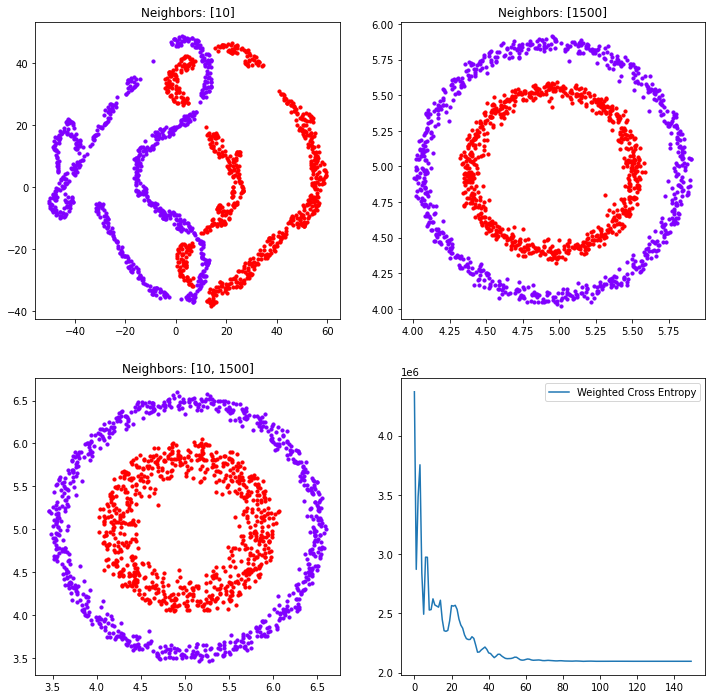

In [4]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss())))

## L2. Symmetric Fuzzy Cross Entropy

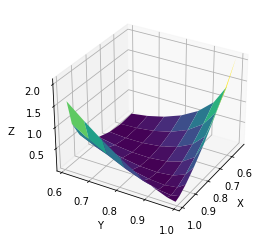

In [5]:
from algorithm import SymmetricLoss
visualize_loss(lambda P, Q: (P - Q) * np.log((P * (1 - Q)) / (Q * (1 - P))))

Running UMAP for neighbors count: [10]
[1]: loss 4928148.866800921
[50]: loss 125236.1360659529
[100]: loss 99336.50997493092
[150]: loss 94165.5077179733
Running UMAP for neighbors count: [1500]
[1]: loss 9067767.241158338
[50]: loss 201343.2728851926
[100]: loss 103293.47373832301
[150]: loss 102724.99577463778
Running UMAP for neighbors count: [10, 1500]
[1]: loss 4011599.49014905
[50]: loss 940500.6760156159
[100]: loss 933592.0892287414
[150]: loss 933019.7884993667
CPU times: user 8min 53s, sys: 27.9 s, total: 9min 21s
Wall time: 3min 38s


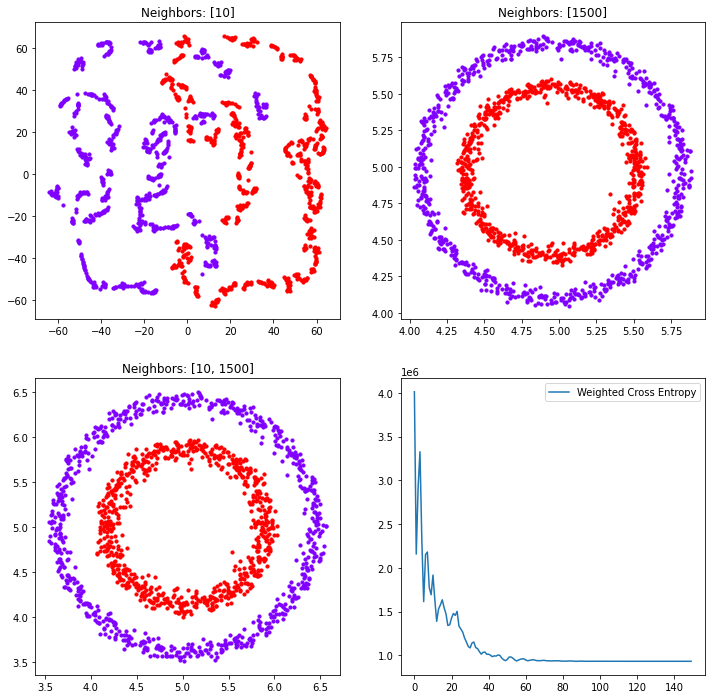

In [6]:
%%time
sl = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=SymmetricLoss())))

## L3. Intuitionistic Fuzzy Cross Entropy

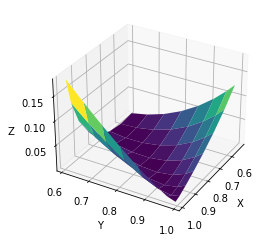

In [7]:
from algorithm import IntuitionisticLoss
visualize_loss(lambda P, Q: P * np.log(P / (0.5*P + 0.5*Q)) + (1 - P)*np.log((1 - P) / (1 - 0.5*(P + Q))))

Running UMAP for neighbors count: [10]
[1]: loss 97266.99039515496
[50]: loss 7823.6899874182545
[100]: loss 7396.019083076841
[150]: loss 7232.672911825873
Running UMAP for neighbors count: [1500]
[1]: loss 1649426.11651771
[50]: loss 968323.4205703348
[100]: loss 904106.2692760404
[150]: loss 896449.7117609818
Running UMAP for neighbors count: [10, 1500]
[1]: loss 1763321.8049890914
[50]: loss 1565347.0944773448
[100]: loss 1521240.3146068677
[150]: loss 1518808.750255635
CPU times: user 9min 2s, sys: 28.4 s, total: 9min 30s
Wall time: 3min 34s


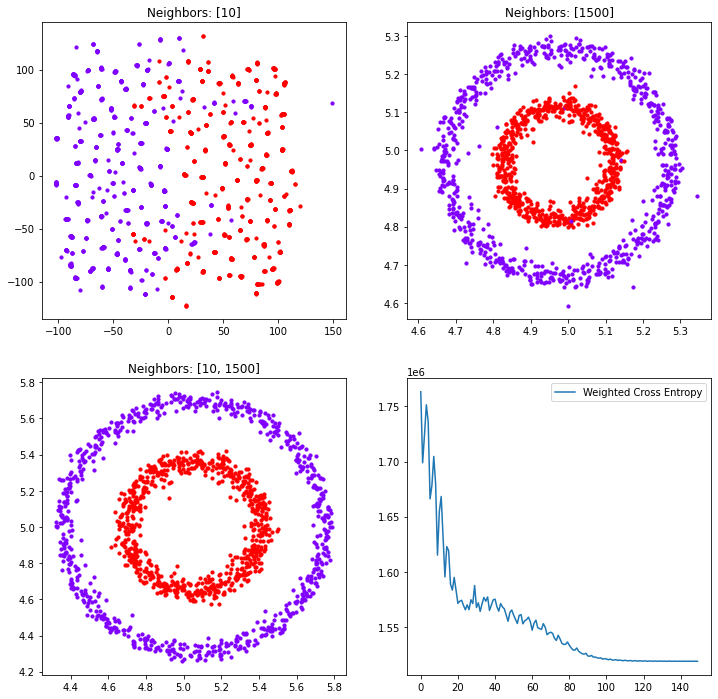

In [8]:
%%time
il = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=0.1 * MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=IntuitionisticLoss())))

## L4. Weighted Fuzzy Cross Entropy

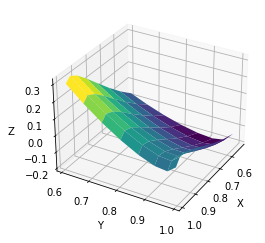

In [9]:
from algorithm import CrossEntropyLoss
visualize_loss(lambda P, Q: P * np.log(P / Q) + 0.05 * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]
[1]: loss 3062.9121850111046
[50]: loss 1353.5229161237858
[100]: loss 973.1449533432315
[150]: loss 971.4433583875292
Running UMAP for neighbors count: [1500]
[1]: loss 6897552.093062811
[50]: loss 2858004.7519808444
[100]: loss 2859164.6489664386
[150]: loss 2858743.7127082543
Running UMAP for neighbors count: [10, 1500]
[1]: loss 4383034.377487169
[50]: loss 1732217.9591775492
[100]: loss 1741932.4495080083
[150]: loss 1741525.486754165
CPU times: user 9min 17s, sys: 22.7 s, total: 9min 40s
Wall time: 4min 7s


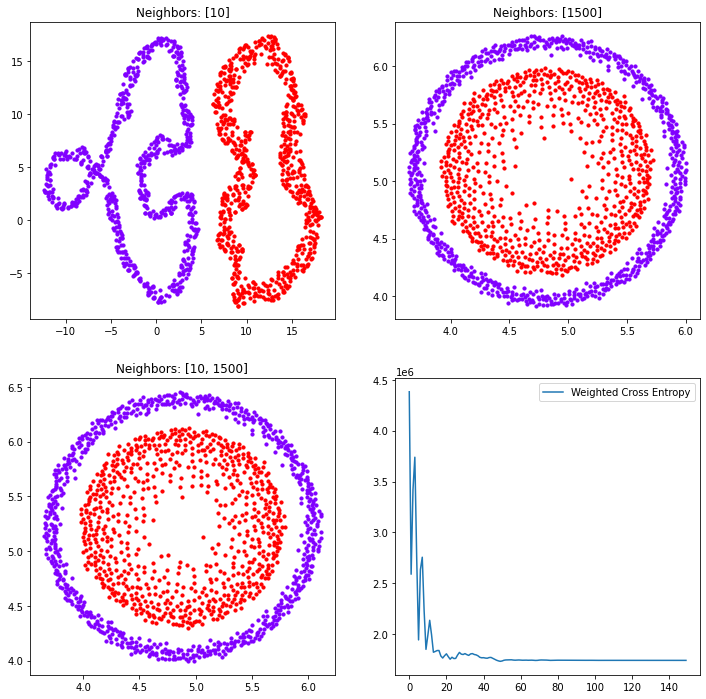

In [10]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss(reduce_repulsion=True))))

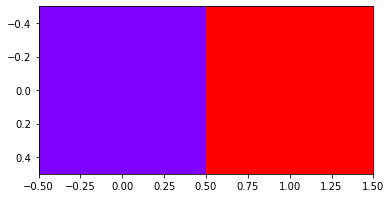

In [11]:
plt.imshow([cm.rainbow(np.linspace(0, 1, max(labels) - min(labels) + 1))])